<a href="https://colab.research.google.com/github/louis-5407/QQQ/blob/main/S%26P500_RNN%E9%A0%90%E6%B8%AC%E6%A8%A1%E5%9E%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#基礎設定
import pandas as pd
from google.colab import drive
drive_name='/content/google_drive'
folder_name = "/content/google_drive/My Drive/Python課程檔案寫入區/"
file_name = '^GSPC_2023Nov.csv' #檔名請自行修改

symbol = '^GSPC_'#代碼也請自行修改

drive.mount(drive_name)
df = pd.read_csv(folder_name + file_name, encoding='utf-8')
adj_close_price = pd.DataFrame(df['Adj Close'])
drive.flush_and_unmount()

Mounted at /content/google_drive


In [ ]:
#基礎設定
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
pd.options.mode.chained_assignment = None #取消顯示pandas資料重設警告

sequence_length = 10 #特徵資料個數
split = 0.95 #訓練資料比率，留下5%資料，做最後的實際測試(Test)

In [ ]:
#資料整理與準備-1
data_all = np.array(adj_close_price).astype(float) #轉為浮點型別矩陣
scaler = MinMaxScaler() #準備函式，等等將數據縮放為0~1之間
data_all = scaler.fit_transform(data_all) #將數據縮放為0~1之間 (標準化，避免極端值影響)
data = []
for i in range(len(data_all) - sequence_length - 1):
   data.append(data_all[i: i + sequence_length + 1]) #每筆data資料有11欄

reshaped_data = np.array(data).astype('float64') #轉為浮點型的陣列型態
x = reshaped_data[:, :-1]
y = reshaped_data[:, -1]

In [ ]:
#資料整理與準備-2
split_boundary = int(reshaped_data.shape[0] * split)#設定分離訓練與測試資料的切點

train_x = x[: split_boundary]  #訓練特徵資料組
train_y = y[: split_boundary]#訓練標籤(label)資料組

test_x = x[split_boundary:]#測試用(test)特徵資料組
test_y = y[split_boundary:] #測試用(test)的標籤(label)資料組


In [ ]:
#建立模型與儲存模型
model = Sequential()
model.add(LSTM(input_shape=(sequence_length,1),units=256,unroll=False))#LSTM層

model.add(Dense(units=1)) #輸出層：1個神經元
model.compile(loss="mse", optimizer="adam", metrics=['accuracy'])

model.fit(train_x, train_y, batch_size=100, epochs=10, validation_split=0.1,verbose=2)

drive.mount(drive_name)  #將Google 雲端硬碟掛載到指定位置
model.save(folder_name+'Stock_rnn_model.h5') #儲存模型

print("\nStock_rnn_model.h5 模型儲存完畢!")

Epoch 1/10
11/11 - 3s - loss: 0.0789 - accuracy: 0.0019 - val_loss: 0.0126 - val_accuracy: 0.0000e+00 - 3s/epoch - 302ms/step
Epoch 2/10
11/11 - 1s - loss: 0.0114 - accuracy: 0.0019 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - 589ms/epoch - 54ms/step
Epoch 3/10
11/11 - 1s - loss: 0.0041 - accuracy: 0.0019 - val_loss: 0.0059 - val_accuracy: 0.0000e+00 - 545ms/epoch - 50ms/step
Epoch 4/10
11/11 - 1s - loss: 0.0022 - accuracy: 0.0019 - val_loss: 6.7199e-04 - val_accuracy: 0.0000e+00 - 538ms/epoch - 49ms/step
Epoch 5/10
11/11 - 1s - loss: 0.0014 - accuracy: 0.0019 - val_loss: 8.1834e-04 - val_accuracy: 0.0000e+00 - 770ms/epoch - 70ms/step
Epoch 6/10
11/11 - 1s - loss: 0.0010 - accuracy: 0.0019 - val_loss: 5.8275e-04 - val_accuracy: 0.0000e+00 - 885ms/epoch - 80ms/step
Epoch 7/10
11/11 - 1s - loss: 9.8426e-04 - accuracy: 0.0019 - val_loss: 4.0492e-04 - val_accuracy: 0.0000e+00 - 914ms/epoch - 83ms/step
Epoch 8/10
11/11 - 1s - loss: 9.4534e-04 - accuracy: 0.0019 - val_loss: 4.6523e-04 - v

In [ ]:
#讀取模型與應用
drive.mount(drive_name)     #將Google 雲端硬碟掛載到指定位置
from keras.models import load_model

model = load_model(folder_name+'Stock_rnn_model.h5')
predict = model.predict(test_x)
predict = np.reshape(predict, (predict.size, )) #轉換為1維矩陣
predict_tran = scaler.inverse_transform([[i] for i in predict]) #還原 預測  (原本為標準化後 0到1的值)
test_y_tran = scaler.inverse_transform(test_y)  #還原 收盤價  (原本為標準化後 0到1的值)

# print(type(predict_tran))

Drive already mounted at /content/google_drive; to attempt to forcibly remount, call drive.mount("/content/google_drive", force_remount=True).
2/2 [==============================] - 0s 17ms/step


Text(0.5, 1.0, '^GSPC__RNN_predict')

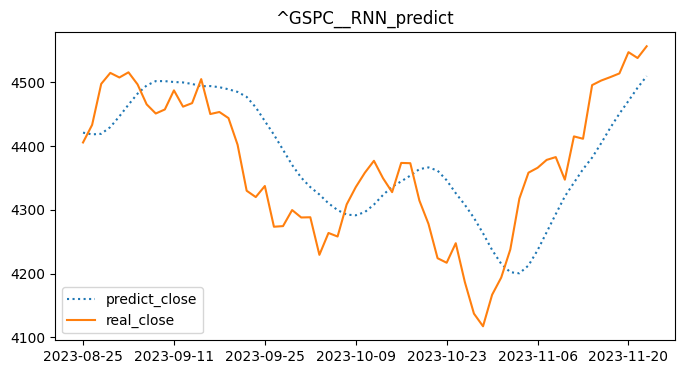

In [ ]:

#繪圖與預測成果整理
##把 Date 從爬取的df中抽取出來，設定為row index
date_test = df.iloc[split_boundary+sequence_length:-1]
date_test= pd.DataFrame(date_test['Date'])
row_indices = date_test['Date'].values.tolist()

df_predict = pd.DataFrame(predict_tran, index = row_indices, columns = ['predict_close'])
df_realdata = pd.DataFrame(test_y_tran, index = row_indices ,columns = ['real_close'])
df_predict_real = pd.concat([df_predict, df_realdata], axis=1 )  #合併兩個df

#線型圖
df_predict_real['predict_close'].plot(figsize=(8, 4), linestyle=":")
df_predict_real['real_close'].plot(figsize=(8, 4))
plt.legend()
plt.title(symbol+'_RNN_predict')

In [ ]:
#繪圖與預測成果整理
import plotly
import plotly.graph_objects as go

fig = go.Figure(go.Scatter(x = df_predict_real.index,  y = df_predict_real["predict_close"],  name = "predict_close"), layout_title_text="0050_RNN預測圖" )

fig.add_scatter(x = df_predict_real.index, y = df_predict_real["real_close"], name = "real_close")

fig.show()
